# Probabilistic Arithmetic Applied to STL

Given a probabilistic representation of state $X(t)$ and an STL formula $\varphi$, we compute a probabilistic representation of robustness $\rho^\varphi(X, t)$. This is done recursively using the ideas of Probabilistic Arithmetic (Williamson and Downs 1988, Papoulis 1968).  

Luke Baird  
(c) MIT Lincoln Laboratory 2025

In [ ]:
import scipy.stats
import numpy as np
import interval
from jax import numpy as jnp
from stlpy_copulas.STL import LinearPredicate
from stlpy_copulas.STL import STLRandomVariable
from matplotlib import pyplot as plt

## Scipy Random Variables
First, we need to create random variables to represent the unknown probability distribution. We will choose i.i.d. Gaussians with $\sigma=1$ and means derived from `main.ipynb`'s control solution.



In [3]:
data = np.load('control_solution.npz', allow_pickle=True)
x = data['x']
x_l = data['x_l']
x_u = data['x_u']

y = np.array([[0, 1]]) @ x # Output

clip=.99 # Confidence bound on Gaussian for finite support

# Create an array of random variables.
Y = []
Y_gaussian = []
supports = []
for j in range(y.shape[1]):
    new_var = STLRandomVariable(scipy.stats.norm(y[0,j], 1), debug=True)
    # new_var = STLRandomVariable(scipy.stats.uniform(y[0,j]-1, 2))
    new_var.compute_inverse_cdf_from_cdf(600,new_var.interval(clip))#np.interval(y[0,j]-1, y[0,j]+1))# new_var.interval(clip))
    Y.append(new_var)
    Y_gaussian.append(scipy.stats.norm(y[0,j], 1))
    # Y_gaussian.append(scipy.stats.uniform(y[0,j]-1, 2))


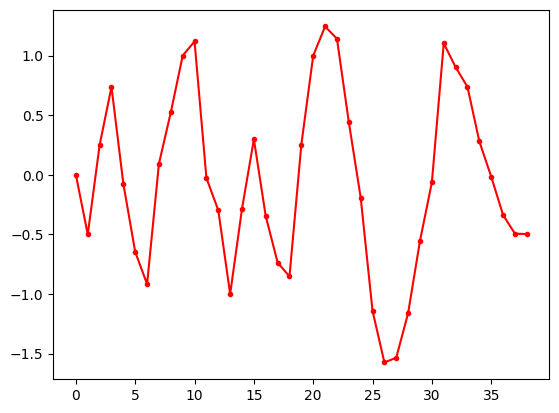

In [4]:
plt.figure()
# plot x
plt.plot(np.arange(0, y.shape[1], 1), y[0,:], 'r.-')
plt.show()

y range is [0.0, 1.0]


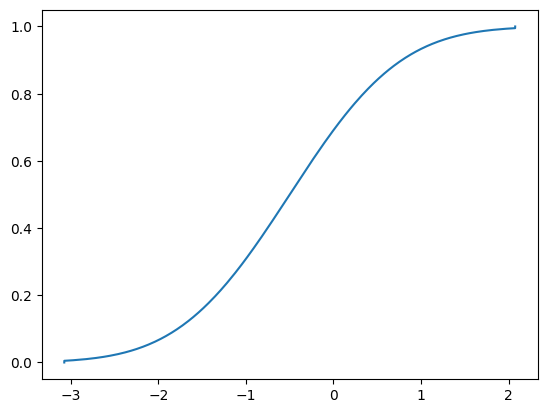

In [5]:
## Unit test: plot the result.
plt.figure()
# Get one branch of the xs.
x_, _x = interval.get_lu(Y[1].xs)
ys = Y[1].ys

plt.plot(x_, ys)
print(f'y range is [{np.min(ys)}, {np.max(ys)}]')
plt.show()

## Left-Continuous Quasi-Inverse
Per (Williamson and Downs), write a routine to compute the quasi-inverse of a distribution

In [ ]:
# The construction of STLRandomVariable belongs to stlpy_copulas.

## STL Formula Creation
`STLRandomVariable` is a class usable by stlpy_copulas. We can create a branch of the repository (and corresponding Python environment) where the $\min$ and $\max$ operators that occur in `stlpy_copulas` are replaced by Algorithm 1 in (Baird and Leahy 2025).

We may need to override the `LinearPredicate` class as well.


In [7]:
# Create an STL formula
dT=0.5
x_geq_1 = LinearPredicate(np.array([1]), np.array([1]), random=True) # 1
x_leq_1 = LinearPredicate(np.array([-1]), np.array([1]), random=True)
phi = (x_geq_1.eventually(0, int(8/dT)) & x_leq_1.eventually(0, int(8/dT))).always(0, int(10/dT))

# Temporary
# phi = (x_geq_1.eventually(0, int(8/dT)))
# phi = (x_geq_1.eventually(0, 1))

# Compute a random variable representing the robustness.
rho = phi.robustness(Y, 0, random=True)

## Evaluation
Use a Monte-Carlo simulation of the random variables to compute the "truth" for the CDFs. That is, we need to take samples from the original Gaussian variables, create a signal, and evaluate the robustness repeatedly. Then, we need to plot the resulting empirical CDF (using numerical integration) and compare it to the results generated by the probabilistic STL computation.

Range of robustness is -0.6759767291397533, 1.880225497596864


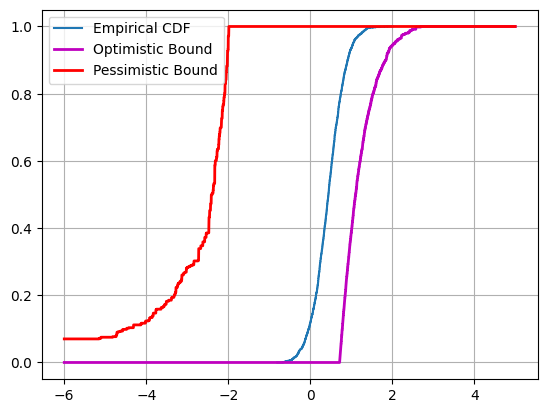

In [8]:
plt.figure()
ax = plt.gca()
numsamples=2000
for i in range(1):
    # TODO: Monte-Carlo Y
    samples = np.zeros((numsamples, y.shape[1]))
    for j in range(y.shape[1]):
        samples[:, j] = Y_gaussian[j].rvs(size=numsamples)
        # Clip samples to
        samples[:, j] = samples[:, j].clip(Y[j].support.l, Y[j].support.u)
    robustness = np.zeros(numsamples)
    for j in range(numsamples):
        robustness[j] = phi.robustness(samples[j, :].reshape((1,y.shape[1])), 0)
    # TODO: feed the samples through phi.robustness

    # TODO: compute a numeric CDF.
    ec = scipy.stats.ecdf(robustness)
    # Make a histogram of the robustness
    # ax.hist(robustness)

    # raise Exception
    ec.cdf.plot(ax)

rho.cdf_from_inverse()
# now we can call cdf_numeric()
xrange = np.arange(np.min(robustness), np.max(robustness), 0.001)
xrange = np.arange(-6, 5, .001)
print(f'Range of robustness is {np.min(robustness)}, {np.max(robustness)}')
ys = np.zeros_like(xrange, dtype=np.interval)
for j in range(xrange.shape[0]):
    ys[j] = rho.cdf_numeric(xrange[j])

# Plot the upper and lower bounds
y_, _y = interval.get_lu(ys)

# Plot these.
plt.plot(xrange, y_, 'm', linewidth=2)
plt.plot(xrange, _y, 'r', linewidth=2)

plt.legend(['Empirical CDF', 'Optimistic Bound', 'Pessimistic Bound'])
plt.grid()

# Make a histogram of the robustness
# plt.hist(robustness, bins=20)
plt.show()

Range of robustness is -0.6759767291397533, 1.880225497596864


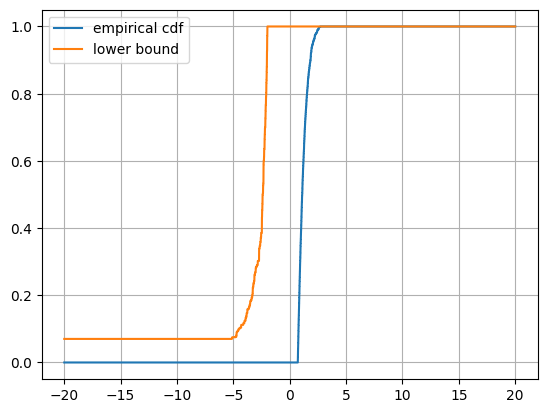

In [9]:
xrange = np.arange(np.min(robustness), np.max(robustness), 0.001)
xrange = np.arange(-20, 20, .0001)
print(f'Range of robustness is {np.min(robustness)}, {np.max(robustness)}')
ys = np.zeros_like(xrange, dtype=np.interval)
for j in range(xrange.shape[0]):
    ys[j] = rho.cdf_numeric(xrange[j])

# Plot the upper and lower bounds
y_, _y = interval.get_lu(ys)

# Plot these.
plt.plot(xrange, y_)
plt.plot(xrange, _y)

plt.legend(['empirical cdf', 'lower bound', 'upper bound'])
plt.grid()

# Make a histogram of the robustness
# plt.hist(robustness, bins=20)
plt.show()